# Porcupine Neural Networks

The code here is for testing PNN approximation on MNIST (only 0's and 1's).

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function

import os
import time
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import arch
import dl_utils
import utils

np.set_printoptions(precision=2,suppress=True)
gpu_id = 0

%matplotlib inline

maindir = './temp_MNIST_pos_labels/'

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

# subset to just 1's and 0's

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

keep_inds_train = (mnist.train.labels == 0) | (mnist.train.labels == 1)
Xtr = mnist.train.images[keep_inds_train]
Ytr = mnist.train.labels[keep_inds_train].astype(float).reshape(-1, 1)
Ytr[Ytr == 0] = 2

keep_inds_test = (mnist.test.labels == 0) | (mnist.test.labels == 1)
Xtt = mnist.test.images[keep_inds_test]
Ytt = mnist.test.labels[keep_inds_test].astype(float).reshape(-1, 1)
Ytt[Ytt == 0] = 2

Ytr_mse = np.sum(np.square(Ytr))
Ytt_mse = np.sum(np.square(Ytt))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# Same as graph_builder_wrapper except for sparser structures
# CURRENTLY ONLY WORKS WITH mlp_noreluout_lastlayernottrainable
def graph_builder_wrapper_PNN(input_dict, build_func=arch.mlp, lr_initial=0.01, max_save=100, feed_u=False):
    graph = build_func(input_dict)
    
    # Loss
    y = tf.placeholder(tf.float32, shape=[None,1])
    total_loss = dl_utils.loss(y, graph['yhat'])
    
    # W gap
    w = {k:tf.placeholder(tf.float32, shape=[None,None]) for k in graph if 'weights' in k}
    total_w_gap = dl_utils.w_gap(w, {k:graph[k] for k in graph if 'weights' in k})
    
    # Find unit vectors (feed_u recommended since due to numerical issues, the line may drift)
    if feed_u:
        u = tf.Variable(np.zeros([input_dict['p'], input_dict['h']]).astype('float32'), trainable=False)
    else:
        u = graph['weights1'] / tf.sqrt(tf.reduce_sum(tf.square(graph['weights1']), 0, keep_dims=True))
    
    # Optimizer
    learning_rate = tf.Variable(lr_initial, name='learning_rate', trainable=False)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads = optimizer.compute_gradients(total_loss)
    modified_grads = []
    for gv in grads:
        if 'w1' in gv[1].name: 
            # Project gradients along unit vectors
            alpha = tf.diag_part(tf.matmul(tf.transpose(u),gv[0]))
            update = u*alpha
            modified_grads.append((update, gv[1]))
        else: 
            modified_grads.append(gv)
            
    opt_step = optimizer.apply_gradients(modified_grads)
    
    graph['y'] = y
    graph['w'] = w
    graph['u'] = u
    graph['grads'] = [i for i in grads if i[0] is not None]
    graph['modified_grads'] = [i for i in modified_grads if i[0] is not None]
    graph['opt_step'] = opt_step
    graph['total_loss'] = total_loss
    graph['total_w_gap'] = total_w_gap
    graph['learning_rate'] = learning_rate
    graph['saver'] = tf.train.Saver(max_to_keep=100)
    return graph

# Used to check to make sure final weights are aligned with initial weights
def check_to_see_if_col_are_same_line(X1,X2,verbose=True):
    u1 = X1 / np.linalg.norm(X1,axis=0)
    u2 = X2 / np.linalg.norm(X2,axis=0)
    dot_products = np.abs(np.diag(np.dot(u1.T,u2)))
    if verbose:
        for i in dot_products: print(i)
        if np.all(np.isclose(dot_products,1)):
            print('columns along same line')
        else:
            print('columns not along same line')            
    return dot_products

def get_acc(X, Y, w, input_dict, build_func):
    Yhat = dl_utils.generate_output(X, w, input_dict, build_func=build_func)
    return np.sum(np.sign(Yhat) == Y)/float(len(Y))

def get_acc_only_1_2_labels(X, Y, w, input_dict, build_func):
    Yhat = dl_utils.generate_output(X, w, input_dict, build_func=build_func)
    Yhat_out = np.zeros(len(Yhat))
    for i, y in enumerate(Yhat):
        Yhat_out[i] = np.argmin(np.abs(y-np.array([1, 2])))+1
    return np.sum(Yhat_out == Y.reshape(-1))/float(len(Y))

In [5]:
# Network parameters
num_epochs = 100
batch_size = 100
build_func = arch.mlp_noreluout_lastlayernottrainable
d = 784    # number of inputs
k_list = [512, 1024, 2048, 4096]

In [6]:
# Performance with a dense network
input_dict = dict(p=d, h=512)
save_file = '%s/mlp_noreluout_lastlayernottrainable.pickle'%(maindir)

if not os.path.exists(save_file):
    tf.reset_default_graph()
    g = dl_utils.graph_builder_wrapper(input_dict, build_func=build_func)
    out = dl_utils.train_no_wtrue(Xtr, Ytr, g, num_epochs, batch_size)
    pickle.dump(out, file(save_file, 'wb'))
else:
    out = pickle.load(file(save_file, 'rb'))

tr_acc = get_acc_only_1_2_labels(Xtr, Ytr, out[1], input_dict, build_func)
test_acc = get_acc_only_1_2_labels(Xtt, Ytt, out[1], input_dict, build_func)

print('Train acc: %.5f'%(tr_acc))
print('Test acc: %.5f'%(test_acc))

Train acc: 0.99415
Test acc: 0.99102


# PNN last layer not trainable

In [7]:
build_func = arch.mlp_noreluout_lastlayernottrainable
np.random.seed(0)

# Performance with a PNN network
for k in k_list:
    
    input_dict = dict(p=d, h=k)
    
    # initialize unit vectors corresponding to lines
    w_init_u = np.random.normal(0, 1, [d, k/2])
    w_init_u /= np.linalg.norm(w_init_u, axis=0)
    w_init_u = np.repeat(w_init_u, 2, axis=1)
    alpha = np.random.uniform(0, 1, k)
    for ii in range(0, len(alpha), 2): alpha[ii] *= -1
    w_init = alpha*w_init_u
    w_init = {'weights1':w_init.astype(np.float32),
              'weights2':np.ones([k, 1]).astype(np.float32)}
    
    # start training
    save_file = '%s/mlp_noreluout_lastlayernottrainable_PNN_hidden%s.pickle'%(maindir, k)
    if not os.path.exists(save_file):
        tf.reset_default_graph()
        g = graph_builder_wrapper_PNN(input_dict, build_func=build_func, feed_u=True)
        out = dl_utils.train_no_wtrue(Xtr, Ytr, g, num_epochs, batch_size, w_initial=w_init, PNN=True, lr_initial=0.001)
        pickle.dump(out, file(save_file, 'wb'))
    else:
        out = pickle.load(file(save_file, 'rb'))
        
    dot_prods = check_to_see_if_col_are_same_line(out[1]['weights1'], w_init['weights1'], verbose=False)
    
    tr_acc = get_acc_only_1_2_labels(Xtr, Ytr, out[1], input_dict, build_func)
    test_acc = get_acc_only_1_2_labels(Xtt, Ytt, out[1], input_dict, build_func)
    
    print('Num final lines close to original: %s'%(np.sum(np.isclose(dot_prods, np.ones(k), atol=1e-2))))
    print('Train acc: %.5f'%(tr_acc))
    print('Test acc: %.5f'%(test_acc))

Num final lines close to original: 506
Train acc: 0.96989
Test acc: 0.98109
Num final lines close to original: 0
Train acc: 0.95001
Test acc: 0.95745
Num final lines close to original: 0
Train acc: 0.90760
Test acc: 0.91348
Num final lines close to original: 0
Train acc: 0.88213
Test acc: 0.89929


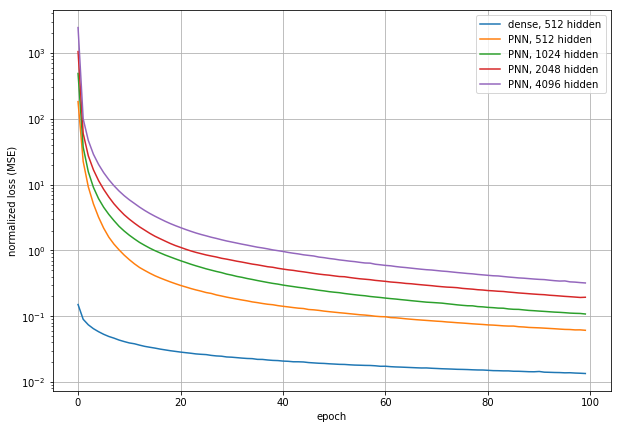

In [8]:
# Plot all losses
plt.figure(figsize=(10, 7))

loss = pickle.load(file('%s/mlp_noreluout_lastlayernottrainable.pickle'%(maindir), 'rb'))[0]
plt.plot(loss, label='dense, 512 hidden')

for k in k_list:
    loss = pickle.load(file('%s/mlp_noreluout_lastlayernottrainable_PNN_hidden%s.pickle'%(maindir, k), 'rb'))[0]
    plt.plot(loss, label='PNN, %s hidden'%(k))
    
plt.xlabel('epoch')
plt.ylabel('normalized loss (MSE)')
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

### last layer not trainable but initialized to smaller values (normal distribution with std 1/sqrt(k))

In [9]:
build_func = arch.mlp_noreluout_lastlayernottrainable
np.random.seed(0)

# Performance with a PNN network
for k in k_list:
    
    input_dict = dict(p=d, h=k)
    
    # initialize unit vectors corresponding to lines
    w_init_u = np.random.normal(0, 1, [d, k/2])
    w_init_u /= np.linalg.norm(w_init_u, axis=0)
    w_init_u = np.repeat(w_init_u, 2, axis=1)
    alpha = np.random.uniform(0, 1, k)
    for ii in range(0, len(alpha), 2): alpha[ii] *= -1
    w_init = alpha*w_init_u
    w_init = {'weights1':w_init.astype(np.float32),
              'weights2':np.random.normal(0, 1./np.sqrt(k), [k, 1]).astype(np.float32)}
    
    # start training
    save_file = '%s/mlp_noreluout_lastlayernottrainable_PNN_hidden%s_smallw2init.pickle'%(maindir, k)
    if not os.path.exists(save_file):
        tf.reset_default_graph()
        g = graph_builder_wrapper_PNN(input_dict, build_func=build_func, feed_u=True)
        out = dl_utils.train_no_wtrue(Xtr, Ytr, g, num_epochs, batch_size, w_initial=w_init, PNN=True, lr_initial=0.01)
        pickle.dump(out, file(save_file, 'wb'))
    else:
        out = pickle.load(file(save_file, 'rb'))
        
    dot_prods = check_to_see_if_col_are_same_line(out[1]['weights1'], w_init['weights1'], verbose=False)
    
    tr_acc = get_acc_only_1_2_labels(Xtr, Ytr, out[1], input_dict, build_func)
    test_acc = get_acc_only_1_2_labels(Xtt, Ytt, out[1], input_dict, build_func)
    
    print('Num final lines close to original: %s'%(np.sum(np.isclose(dot_prods, np.ones(k), atol=1e-2))))
    print('Train acc: %.5f'%(tr_acc))
    print('Test acc: %.5f'%(test_acc))

Num final lines close to original: 509
Train acc: 0.85572
Test acc: 0.85390
Num final lines close to original: 0
Train acc: 0.91078
Test acc: 0.90071
Num final lines close to original: 0
Train acc: 0.91534
Test acc: 0.90213
Num final lines close to original: 0
Train acc: 0.93091
Test acc: 0.92435


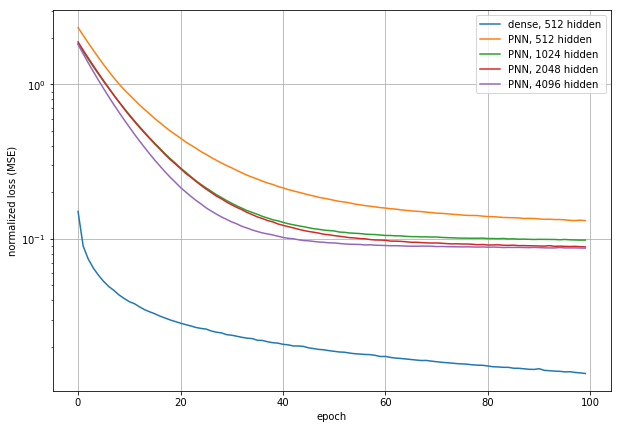

In [10]:
# Plot all losses
plt.figure(figsize=(10, 7))

loss = pickle.load(file('%s/mlp_noreluout_lastlayernottrainable.pickle'%(maindir), 'rb'))[0]
plt.plot(loss, label='dense, 512 hidden')

for k in k_list:
    loss = pickle.load(file('%s/mlp_noreluout_lastlayernottrainable_PNN_hidden%s_smallw2init.pickle'%(maindir, k), 'rb'))[0]
    plt.plot(loss, label='PNN, %s hidden'%(k))
    
plt.xlabel('epoch')
plt.ylabel('normalized loss (MSE)')
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

### last layer not trainable but initialized to smaller values (absolute value of normal distribution with std 1/sqrt(k))

In [11]:
build_func = arch.mlp_noreluout_lastlayernottrainable
np.random.seed(0)

# Performance with a PNN network
for k in k_list:
    
    input_dict = dict(p=d, h=k)
    
    # initialize unit vectors corresponding to lines
    w_init_u = np.random.normal(0, 1, [d, k/2])
    w_init_u /= np.linalg.norm(w_init_u, axis=0)
    w_init_u = np.repeat(w_init_u, 2, axis=1)
    alpha = np.random.uniform(0, 1, k)
    for ii in range(0, len(alpha), 2): alpha[ii] *= -1
    w_init = alpha*w_init_u
    w_init = {'weights1':w_init.astype(np.float32),
              'weights2':np.abs(np.random.normal(0, 1./np.sqrt(k), [k, 1])).astype(np.float32)}
    
    # start training
    save_file = '%s/mlp_noreluout_lastlayernottrainable_PNN_hidden%s_smallw2initpos.pickle'%(maindir, k)
    if not os.path.exists(save_file):
        tf.reset_default_graph()
        g = graph_builder_wrapper_PNN(input_dict, build_func=build_func, feed_u=True)
        out = dl_utils.train_no_wtrue(Xtr, Ytr, g, num_epochs, batch_size, w_initial=w_init, PNN=True, lr_initial=0.01)
        pickle.dump(out, file(save_file, 'wb'))
    else:
        out = pickle.load(file(save_file, 'rb'))
        
    dot_prods = check_to_see_if_col_are_same_line(out[1]['weights1'], w_init['weights1'], verbose=False)
    
    tr_acc = get_acc_only_1_2_labels(Xtr, Ytr, out[1], input_dict, build_func)
    test_acc = get_acc_only_1_2_labels(Xtt, Ytt, out[1], input_dict, build_func)
    
    print('Num final lines close to original: %s'%(np.sum(np.isclose(dot_prods, np.ones(k), atol=1e-2))))
    print('Train acc: %.5f'%(tr_acc))
    print('Test acc: %.5f'%(test_acc))

Num final lines close to original: 512
Train acc: 0.93410
Test acc: 0.93570
Num final lines close to original: 0
Train acc: 0.96128
Test acc: 0.95839
Num final lines close to original: 0
Train acc: 0.96756
Test acc: 0.96407
Num final lines close to original: 0
Train acc: 0.95543
Test acc: 0.94752


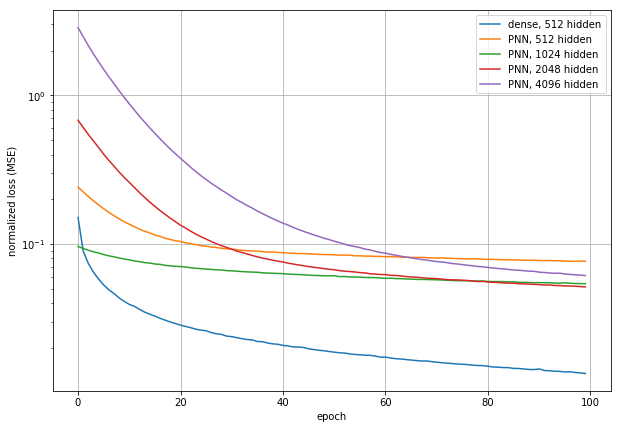

In [12]:
# Plot all losses
plt.figure(figsize=(10, 7))

loss = pickle.load(file('%s/mlp_noreluout_lastlayernottrainable.pickle'%(maindir), 'rb'))[0]
plt.plot(loss, label='dense, 512 hidden')

for k in k_list:
    loss = pickle.load(file('%s/mlp_noreluout_lastlayernottrainable_PNN_hidden%s_smallw2initpos.pickle'%(maindir, k), 'rb'))[0]
    plt.plot(loss, label='PNN, %s hidden'%(k))
    
plt.xlabel('epoch')
plt.ylabel('normalized loss (MSE)')
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

# PNN last layer trainable

In [13]:
build_func = arch.mlp_noreluout
np.random.seed(0)

# Performance with a PNN network
for k in k_list:
    
    input_dict = dict(p=d, h=k)
    
    # initialize unit vectors corresponding to lines
    w_init_u = np.random.normal(0, 1, [d, k/2])
    w_init_u /= np.linalg.norm(w_init_u, axis=0)
    w_init_u = np.repeat(w_init_u, 2, axis=1)
    alpha = np.random.uniform(0, 1, k)
    for ii in range(0, len(alpha), 2): alpha[ii] *= -1
    w_init = alpha*w_init_u
    w_init = {'weights1':w_init.astype(np.float32),
              'weights2':np.random.normal(0, 1./np.sqrt(k), [k, 1]).astype(np.float32)}
    
    # start training
    save_file = '%s/mlp_noreluout_PNN_hidden%s.pickle'%(maindir, k)
    if not os.path.exists(save_file):
        tf.reset_default_graph()
        g = graph_builder_wrapper_PNN(input_dict, build_func=build_func, feed_u=True)
        out = dl_utils.train_no_wtrue(Xtr, Ytr, g, num_epochs, batch_size, w_initial=w_init, PNN=True, lr_initial=0.001)
        pickle.dump(out, file(save_file, 'wb'))
    else:
        out = pickle.load(file(save_file, 'rb'))
        
    dot_prods = check_to_see_if_col_are_same_line(out[1]['weights1'], w_init['weights1'], verbose=False)
    
    tr_acc = get_acc_only_1_2_labels(Xtr, Ytr, out[1], input_dict, build_func)
    test_acc = get_acc_only_1_2_labels(Xtt, Ytt, out[1], input_dict, build_func)
    
    print('Num final lines close to original: %s'%(np.sum(np.isclose(dot_prods, np.ones(k), atol=1e-2))))
    print('Train acc: %.5f'%(tr_acc))
    print('Test acc: %.5f'%(test_acc))

Num final lines close to original: 512
Train acc: 0.96817
Test acc: 0.96879
Num final lines close to original: 0
Train acc: 0.98486
Test acc: 0.98440
Num final lines close to original: 0
Train acc: 0.99424
Test acc: 0.99622
Num final lines close to original: 0
Train acc: 0.99750
Test acc: 0.99811


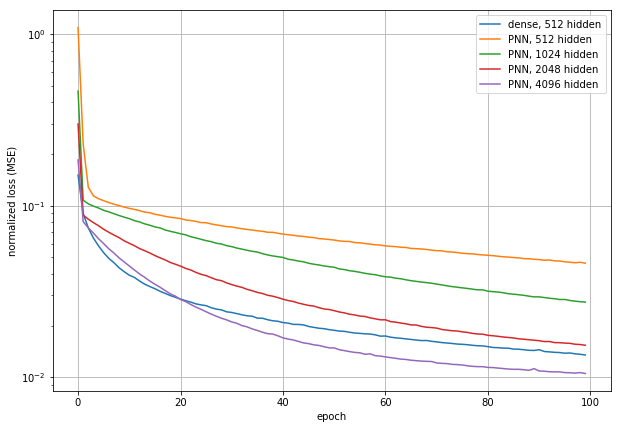

In [14]:
# Plot all losses
plt.figure(figsize=(10, 7))

loss = pickle.load(file('%s/mlp_noreluout_lastlayernottrainable.pickle'%(maindir), 'rb'))[0]
plt.plot(loss, label='dense, 512 hidden')

for k in k_list:
    loss = pickle.load(file('%s/mlp_noreluout_PNN_hidden%s.pickle'%(maindir, k), 'rb'))[0]
    plt.plot(loss, label='PNN, %s hidden'%(k))
    
plt.xlabel('epoch')
plt.ylabel('normalized loss (MSE)')
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()